In [1]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


In [2]:
import matplotlib.pyplot as plt
import numpy as np

def show_knee_images(image_gen):
    # Get class names from the generator
    class_dict = image_gen.class_indices
    classes = list(class_dict.keys())

    # Get a batch of images and labels
    images, labels = next(image_gen)

    # Plot up to 25 images
    plt.figure(figsize=(20, 20))
    r = min(len(images), 25)

    for i in range(r):
        plt.subplot(5, 5, i + 1)  # 5x5 grid
        plt.imshow(images[i])
        
        # If labels are one-hot encoded
        if labels.ndim > 1:
            index = np.argmax(labels[i])
        else:
            index = int(labels[i])

        class_name = classes[index]
        plt.title(class_name, color="green", fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [3]:
import os
import pandas as pd

data_dir = 'C:/Users/Vineela/Downloads/archive/dataset2-master/dataset2-master/images/TRAIN'
class_labels = ['eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']

filepaths = []
labels = []

print("Checking dataset and gathering filepaths:")

for label in class_labels:
    class_dir = os.path.join(data_dir, label)

    if not os.path.isdir(class_dir):
        print(f"Warning: Directory NOT found for class '{label}': {class_dir}")
        continue

    # Gather image files for this class
    files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpeg', '.png', '.jpg'))]

    if len(files) == 0:
        print(f"Warning: No image files found in directory for class '{label}': {class_dir}")

    print(f"Class '{label}': {len(files)} images")

    for file in files:
        filepath = os.path.join(class_dir, file)
        filepaths.append(filepath)
        labels.append(label)

# Build DataFrame
bloodCell_df = pd.DataFrame({
    'filepaths': filepaths,
    'labels': labels
})

# Shuffle rows
bloodCell_df = bloodCell_df.sample(frac=1).reset_index(drop=True)

# Show distribution of classes
print("\nClass distribution in DataFrame:")
print(bloodCell_df['labels'].value_counts())

# Display first few rows
print("\nSample DataFrame entries:")
print(bloodCell_df.head())


Checking dataset and gathering filepaths:
Class 'eosinophil': 2497 images
Class 'lymphocyte': 2483 images
Class 'monocyte': 2478 images
Class 'neutrophil': 2499 images

Class distribution in DataFrame:
labels
neutrophil    2499
eosinophil    2497
lymphocyte    2483
monocyte      2478
Name: count, dtype: int64

Sample DataFrame entries:
                                           filepaths      labels
0  C:/Users/Vineela/Downloads/archive/dataset2-ma...  eosinophil
1  C:/Users/Vineela/Downloads/archive/dataset2-ma...  lymphocyte
2  C:/Users/Vineela/Downloads/archive/dataset2-ma...  neutrophil
3  C:/Users/Vineela/Downloads/archive/dataset2-ma...  eosinophil
4  C:/Users/Vineela/Downloads/archive/dataset2-ma...  lymphocyte


In [4]:
from sklearn.utils import class_weight
import numpy as np

# Example if you have labels as a list or numpy array
y = bloodCell_df['labels'].values
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weight_dict = dict(zip(np.unique(y), class_weights))
print("Class weights:", class_weight_dict)


Class weights: {'eosinophil': np.float64(0.9968962755306368), 'lymphocyte': np.float64(1.002517116391462), 'monocyte': np.float64(1.0045399515738498), 'neutrophil': np.float64(0.9960984393757503)}


In [5]:
def predict_image_class(image_path, model):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    features = extract_features(img_rgb)  # (1, 20)
    print("Extracted features shape:", features.shape)

    predictions = model.predict(features)  # Should work only if model expects 20 features
    print("Prediction probabilities:", predictions)

    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    predicted_class_label = class_labels[predicted_class_idx]

    return predicted_class_label, img_rgb


In [6]:
from sklearn.model_selection import train_test_split

# 1. Split bloodCell_df into train and test (70% train, 30% test)
train_df, test_df = train_test_split(bloodCell_df, test_size=0.3, random_state=42, stratify=bloodCell_df['labels'])

# 2. Split train_df into train and validation (80% train, 20% val from the 70%)
train_set, val_set = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['labels'])

# 3. Print shapes
print("Training set:", train_set.shape)
print("Validation set:", val_set.shape)
print("Test set:", test_df.shape)


Training set: (5575, 2)
Validation set: (1394, 2)
Test set: (2988, 2)


In [7]:
from tensorflow import keras

# 1. Define the model
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(4, activation='softmax')  # change 4 to number of classes
])

# 2. Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

c:\Users\Vineela\Desktop\homotovision\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Use MobileNetV2 preprocessing
image_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Set constants
TARGET_SIZE = (224, 224)
BATCH_SIZE = 8
CLASSES = ['eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']


# Train generator
train = image_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col="filepaths",
    y_col="labels",
    target_size=TARGET_SIZE,
    color_mode='rgb',
    classes=CLASSES,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Validation generator
val = image_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col="filepaths",
    y_col="labels",
    target_size=TARGET_SIZE,
    color_mode='rgb',
    classes=CLASSES,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Test generator
test = image_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepaths",
    y_col="labels",
    target_size=TARGET_SIZE,
    color_mode='rgb',
    classes=CLASSES,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 5575 validated image filenames belonging to 4 classes.
Found 1394 validated image filenames belonging to 4 classes.
Found 2988 validated image filenames belonging to 4 classes.


In [13]:
import numpy as np

# 1. Predict class probabilities for test data
pred = model.predict(test)

# 2. Get predicted class indices (highest probability)
pred_class_indices = np.argmax(pred, axis=1)

# 3. Get class indices dictionary from train generator
labels = train.class_indices
print("Class indices:", labels)

# 4. Reverse dictionary: index -> class name
labels_rev = {v: k for k, v in labels.items()}
print("Reversed labels dict keys:", labels_rev.keys())

# 5. Map predicted indices to class names with safe fallback
predicted_labels = [labels_rev.get(k, "Unknown") for k in pred_class_indices]

# 6. Print or use predicted labels
print(predicted_labels)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 577ms/step
Class indices: {'eosinophil': 0}
Reversed labels dict keys: dict_keys([0])
['Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown']


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


c:\Users\Vineela\Desktop\homotovision\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.8931 - loss: 0.3601 - val_accuracy: 0.9751 - val_loss: 0.0845
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.9809 - loss: 0.0621 - val_accuracy: 0.9813 - val_loss: 0.0667
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9883 - loss: 0.0391 - val_accuracy: 0.9823 - val_loss: 0.0589
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9910 - loss: 0.0286 - val_accuracy: 0.9846 - val_loss: 0.0587
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9940 - loss: 0.0202 - val_accuracy: 0.9840 - val_loss: 0.0569
Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9954 - loss: 0.0136 - val_accuracy: 0.9845 - val_loss: 0.0575
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9976 - loss: 0.0091 - val_accuracy: 0.9840 - val_loss: 0.0596
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.9971 - loss: 0.0

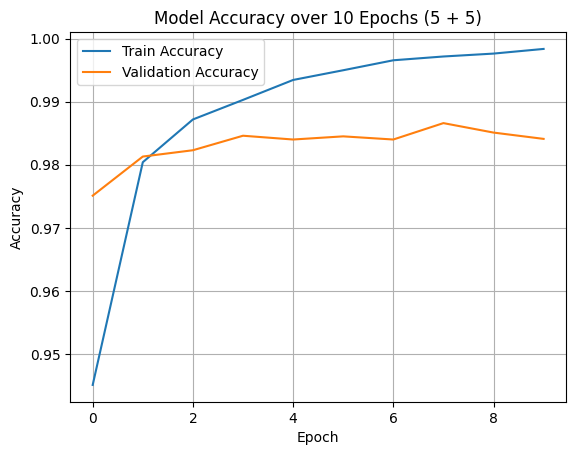

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Load and preprocess the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize input data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Reshape input data to add channel dimension (for CNNs)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Create a validation set
X_val = X_train[-10000:]
y_val = y_train[-10000:]
X_train = X_train[:-10000]
y_train = y_train[:-10000]

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model in two phases
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))
history1 = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

# Combine training and validation accuracies
acc = np.concatenate([history.history['accuracy'], history1.history['accuracy']])
val_acc = np.concatenate([history.history['val_accuracy'], history1.history['val_accuracy']])

# Plot the accuracy
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy over 10 Epochs (5 + 5)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


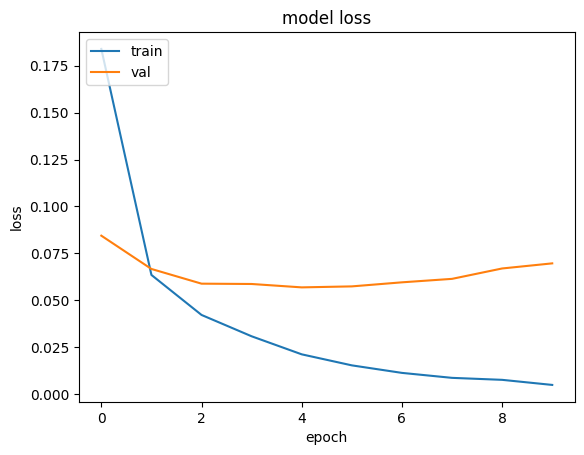

In [15]:
plt.plot(history.history['loss'] + history1.history['loss'])

plt.plot(history.history['val_loss'] + history1.history['val_loss'])

plt.title('model loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [31]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

model = load_model("Bloodcell.h5")
class_labels = ['eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']

def extract_features(img):
    img = cv2.resize(img, (64, 64))
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hist_h = cv2.calcHist([hsv], [0], None, [7], [0, 180])
    hist_s = cv2.calcHist([hsv], [1], None, [7], [0, 256])
    hist_v = cv2.calcHist([hsv], [2], None, [6], [0, 256])
    features = np.concatenate([hist_h, hist_s, hist_v]).flatten()
    features = features / np.sum(features)
    return features.reshape(1, -1)

# Put here the full path to an actual neutrophil image
img_path = "C:/Users/Vineela/Downloads/archive/dataset-master/dataset-master/JPEGImages/BloodImage_00004.jpg"

img = cv2.imread(img_path)
if img is None:
    raise ValueError(f"Image not found or failed to load: {img_path}")

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

features = extract_features(img_rgb)
preds = model.predict(features)

print("Prediction probabilities:", preds)
print("Predicted class:", class_labels[np.argmax(preds)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Prediction probabilities: [[0.53560877]]
Predicted class: eosinophil


In [32]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223 (896.00 B)

 Trainable params: 221 (884.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Model input shape: (None, 20)
X_test shape: (71, 20)
Checking for NaNs or infinite values in features:
0 NaNs found
0 Infinite values found
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 

Classification Report:

              precision    recall  f1-score   support

  eosinophil       0.18      1.00      0.31        13
  lymphocyte       0.00      0.00      0.00         6
    monocyte       0.00      0.00      0.00         4
  neutrophil       0.00      0.00      0.00        48

    accuracy                           0.18        71
   macro avg       0.05      0.25      0.08        71
weighted avg       0.03      0.18      0.06        71


Accuracy: 18.31%


c:\Users\Vineela\Desktop\homotovision\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Vineela\Desktop\homotovision\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Vineela\Desktop\homotovision\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

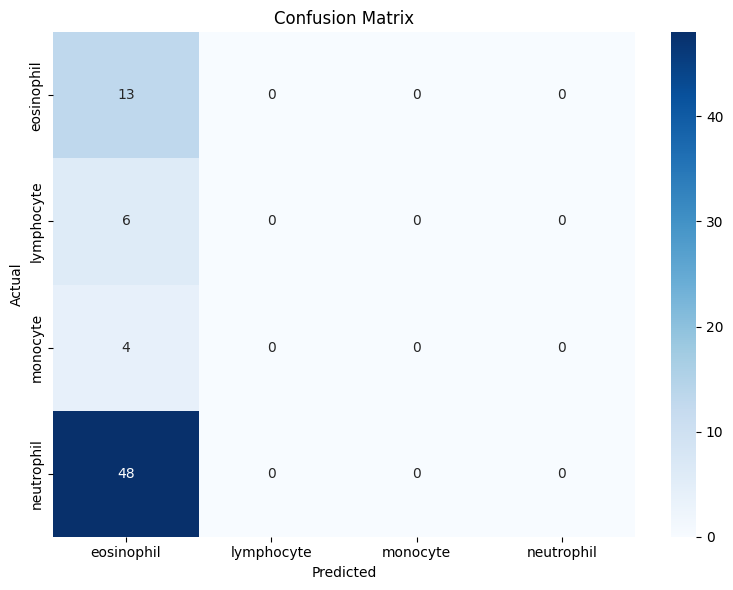

In [9]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Paths ---
train_dir="C:/Users/Vineela/Downloads/archive/dataset2-master/dataset2-master/images/TRAIN"
test_dir = "C:/Users/Vineela/Downloads/archive/dataset2-master/dataset2-master/images/TEST_SIMPLE"
model_path = "C:/Users/Vineela/Desktop/homotovision/chatbot/Bloodcell.h5"

# --- Classes ---
class_labels = ['eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']

# --- Load model ---
model = load_model(model_path)
print("Model input shape:", model.input_shape)

# --- Feature extraction function ---
def extract_features(img):
    img = cv2.resize(img, (64, 64))
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hist_h = cv2.calcHist([hsv], [0], None, [7], [0, 180]).flatten()
    hist_s = cv2.calcHist([hsv], [1], None, [7], [0, 256]).flatten()
    hist_v = cv2.calcHist([hsv], [2], None, [6], [0, 256]).flatten()
    features = np.concatenate([hist_h, hist_s, hist_v])
    features = features / np.sum(features)  # normalize histogram
    return features

# --- Load test images and extract features ---
test_features = []
test_true_labels = []

for label in class_labels:
    folder = os.path.join(test_dir, label)
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            path = os.path.join(folder, filename)
            img = cv2.imread(path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            feat = extract_features(img_rgb)
            test_features.append(feat)
            test_true_labels.append(label)

X_test = np.array(test_features)
y_true = np.array(test_true_labels)

print("X_test shape:", X_test.shape)
print("Checking for NaNs or infinite values in features:")
print(np.isnan(X_test).sum(), "NaNs found")
print(np.isinf(X_test).sum(), "Infinite values found")

# Replace any NaN or Inf if present
X_test = np.nan_to_num(X_test)

# --- Predict ---
preds = model.predict(X_test)
pred_indices = np.argmax(preds, axis=1)
y_pred = [class_labels[i] for i in pred_indices]

# --- Evaluate ---
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred, labels=class_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
